라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'doRegressor_tank1rere'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))
    

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 사료 공급 데이터 null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

In [4]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_tank = japonica_training[japonica_training['tank_id']==tank]
japonica_validation_tank = japonica_validation[japonica_validation['tank_id']==tank]

In [5]:
# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training_tank[feature_origin]
japonica_validation_features = japonica_validation_tank[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

In [6]:
# 시계열 데이터의 개수 확인
training_counts = japonica_training_features.groupby(japonica_training_features['mea_dt'].dt.date).size()
#validation_counts = japonica_validation_features.groupby(japonica_validation_features.index.mea_dt).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_data = japonica_training_features[~japonica_training_features['mea_dt'].dt.date.isin(to_delete)]

#to_delete = validation_counts[validation_counts != 1440].index
#japonica_validation_data = japonica_validation_features[~japonica_validation_features.index.floor('D').isin(to_delete)]

In [7]:
japonica_validation_data = japonica_validation_features

In [8]:
# 날짜 데이터를 인덱스로 전환
japonica_training_data.set_index('mea_dt', inplace=True)
japonica_validation_data.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_data.sort_index()
japonica_validation_data = japonica_validation_data.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [9]:
japonica_training_features_X = japonica_training_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [10]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)


In [11]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [12]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 9
nCar: 64621 nVar: 180
nCar: 74120 nVar: 9
nCar: 74120 nVar: 180


In [13]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [14]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 9
nCar: 64441 nVar: 180
nCar: 73940 nVar: 9
nCar: 73940 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [15]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 9), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-08 16:28:37.075245: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 16:28:37.751915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 128)          70656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 180)               5940      
Total params: 138,420
Trainable params: 138,420
Non-trainable params: 0
_________________________________________________________________


2023-07-08 16:28:39.593431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-08 16:28:43.136278: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-08 16:28:44.252136: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 110s 52ms/step - loss: 5.0307 - mae: 1.4340 - r_squared: -2.7396 - val_loss: 1.5424 - val_mae: 0.9201 - val_r_squared: -37.9434
Epoch 2/200
2014/2014 [==============================] - 102s 51ms/step - loss: 1.4700 - mae: 0.9113 - r_squared: -0.0313 - val_loss: 1.5385 - val_mae: 0.9203 - val_r_squared: -37.5246
Epoch 3/200
2014/2014 [==============================] - 101s 50ms/step - loss: 1.4709 - mae: 0.9116 - r_squared: -0.0327 - val_loss: 1.5579 - val_mae: 0.9245 - val_r_squared: -38.8879
Epoch 4/200
2014/2014 [==============================] - 101s 50ms/step - loss: 0.7088 - mae: 0.5726 - r_squared: 0.4985 - val_loss: 0.3454 - val_mae: 0.3969 - val_r_squared: -3.0089
Epoch 5/200
2014/2014 [==============================] - 101s 50ms/step - loss: 0.3549 - mae: 0.3937 - r_squared: 0.7429 - val_loss: 0.3534 - val_mae: 0.4138 - val_r_squared: -4.0359
Epoch 6/200
2014/2014 [==============================] - 101s 50ms/step - loss: 0.3421 - ma

모델 평가

In [15]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'doRegressor_tank1'

In [16]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('Day')
    plt.ylabel('DO')
    plt.title('day time')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [17]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

2023-07-10 09:43:13.827064: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 09:43:14.393457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 435 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


[[ 0.29121935 -0.10079902  0.01666956 ... -0.6004437  -0.16817012
  -0.04159693]
 [ 0.03956015 -0.11181694 -0.07952528 ...  0.18301386 -0.17854315
  -0.03003434]
 [ 0.02970805 -0.1093411  -0.04216427 ...  0.19878532 -0.08591366
   0.04948305]
 ...
 [ 0.01890536  0.02143522 -0.08100247 ...  0.11220511  0.12852865
   0.04155739]
 [-0.21571814  0.07178771 -0.03119239 ... -0.20642029  0.11140165
   0.11056063]
 [-0.2543157  -0.0122563  -0.00677424 ... -0.28663573 -0.02572359
   0.07357241]]


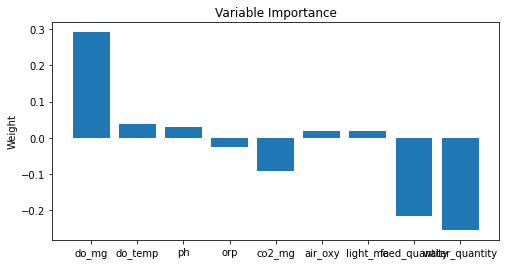

In [18]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [20]:
tank = 1

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_tank = japonica_validation[japonica_validation['tank_id']==tank]

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation_tank[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_features.groupby(japonica_validation_features['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_data = japonica_validation_features[~japonica_validation_features['mea_dt'].dt.date.isin(to_delete)]

# 날짜 데이터를 인덱스로 전환
japonica_validation_data.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_data.sort_index()

In [21]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-09-01 00:00':'2021-09-30 23:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-09-01 03:00':'2021-10-01 02:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 192 nVar: 9
nCar: 34560 nVar: 1
nCar: 192 nVar: 180


In [22]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

2023-07-10 09:44:09.102820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-10 09:44:11.090390: E tensorflow/stream_executor/cuda/cuda_dnn.cc:374] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-07-10 09:44:11.091248: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at cudnn_rnn_ops.cc:1555 : Unknown: Fail to find the dnn implementation.


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_predict_function_3055]

Function call stack:
predict_function -> predict_function -> predict_function


In [ ]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-09-16 00:00':'2021-09-23 23:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-09-16 03:00':'2021-09-24 02:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

In [ ]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-09-23 00:00':'2021-09-23 23:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-09-23 03:00':'2021-09-24 02:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)  # 모든 행 표시
pd.set_option('display.max_columns', None)  # 모든 열 표시


In [ ]:
one_day_data = japonica_validation_data.loc['2021-09-23 00:00':'2021-09-23 23:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
oneday_X_test

In [ ]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-09-23 09:00':'2021-09-23 11:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-09-23 12:00':'2021-09-23 14:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

In [ ]:
oneday_X_test